# 1. Collect and explore the data

## Goals

This notebook aims to explore, clean, and structure the options data that will be used in the pricing modeling project (Black-Scholes, Heston, etc.).

Therefore, this notebook analyzes:
- Structure and characteristic of the option market-
- Relevant filters to ensure data quality
- Calculation of useful features as `mid price`, `spread`, `time to maturity (T)` and `interest free rate`

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os

sns.set(style="darkgrid")
%matplotlib inline

## 1.1. Downloading the data.

In this notebook section, I will download the data from YahooFinance. The financial asset choose is the `^SPX` ticker. The time to maturity is also computed.

In [2]:
ticker_symbol = "^SPX"
ticker = yf.Ticker(ticker_symbol)

expirations = ticker.options
print(f"Available expirations from {expirations[0]} to {expirations[len(expirations)-1]}")

Available expirations from 2025-07-29 to 2030-12-20


In [3]:
options_df = []

for expiry in expirations[1:]:
    try:
        option_chain = ticker.option_chain(expiry)
        expiry_date = datetime.strptime(expiry, "%Y-%m-%d")
        T = (expiry_date - datetime.today()).days/365.0
        

        for df, opt_type in zip([option_chain.calls, option_chain.puts], ["call", "put"]):
            df = df.copy()
            df["Type"] = opt_type
            df["T"] = T
            options_df.append(df)
        
    except Exception as e:
        print(f"Error with expriry {expiry}: e")

options_df = pd.concat(options_df, ignore_index=True)
options_df.head()

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,Type,T
0,SPXW250730C04400000,2025-07-25 15:50:47+00:00,4400.0,1980.44,1997.7,2012.1,0.0,0.0,5.0,8.0,2.783817,True,REGULAR,USD,call,0.0
1,SPXW250730C04600000,2025-07-23 14:09:57+00:00,4600.0,1727.63,1797.8,1812.2,0.0,0.0,NaN,3.0,2.501835,True,REGULAR,USD,call,0.0
2,SPXW250730C05250000,2025-07-23 18:50:30+00:00,5250.0,1108.25,1147.7,1162.1,0.0,0.0,2.0,2.0,1.629091,True,REGULAR,USD,call,0.0
3,SPXW250730C05325000,2025-07-25 13:46:07+00:00,5325.0,1049.13,1072.9,1087.4,0.0,0.0,2.0,2.0,1.538027,True,REGULAR,USD,call,0.0
4,SPXW250730C05500000,2025-06-25 17:08:28+00:00,5500.0,622.16,888.8,903.2,0.0,0.0,NaN,2.0,1.100896,True,REGULAR,USD,call,0.0


## 1.2. Data preprocessing

In this section, I apply relevant filters to guarantee that: 
- Options have enough liquidity (`openInterest > X`)
- Do not have inconsistencies (`bid > ask`)
- Options are **vanilla**

The `mid price` y `spread` are also computed for each action. The `interest free rate` is interpolated from USA treasure bill interest.

In [4]:
def filter_options(df, min_open_interest=10):
    useful_cols = ['strike', 'bid', 'ask', 'lastPrice', 'openInterest', 'impliedVolatility', 'Type', 'T']
    df = df[useful_cols].copy()
    df = df[df['openInterest'] > min_open_interest]
    df = df[df['bid'] > 0]
    df = df[df['ask'] > 0]
    df = df[df['bid'] < df['ask']]
    df["mid"] = (df["bid"] + df["ask"]) / 2
    df["spread"] = df["ask"] - df["bid"]
    return df

options_df = filter_options(options_df)
print(options_df.shape)

(11477, 10)


In [5]:
#interest free rates 29-july-2025
tenors = np.array([0.25, 0.5, 1.0, 2.0, 5.0])
rates = np.array([0.0433, 0.0426, 0.0408, 0.0391, 0.0396])

def interp_rate(T, tenors, rates):
    return np.interp(T, tenors, rates)
    
options_df['risk_free_rate'] = options_df['T'].apply(lambda T: interp_rate(T, tenors, rates))

options_df.head()

,strike,bid,ask,lastPrice,openInterest,impliedVolatility,Type,T,mid,spread,risk_free_rate
16,5960.0,438.2,452.5,397.19,18.0,0.730319,call,0.0,445.35,14.3,0.0433
17,5970.0,428.2,442.5,387.26,15.0,0.717257,call,0.0,435.35,14.3,0.0433
19,6000.0,397.9,412.3,381.44,41.0,0.674899,call,0.0,405.10,14.4,0.0433
20,6015.0,383.0,397.4,381.42,11.0,0.656376,call,0.0,390.20,14.4,0.0433
21,6025.0,373.0,387.4,371.42,30.0,0.643177,call,0.0,380.20,14.4,0.0433


## 1.3. Initial visulatization

Through a scatter plot, this section allow me to visualize the implied volatility estimated by `YahooFinance`.

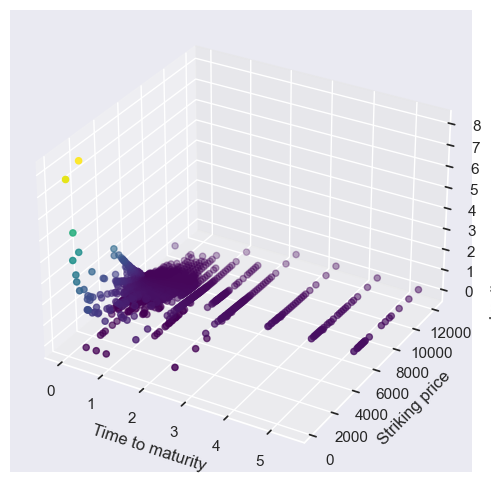

In [6]:
fig = plt.figure(figsize=(8, 6))

call_options = options_df[options_df['Type'] == 'call']

ax = fig.add_subplot(111, projection='3d')
ax.scatter(call_options['T'], call_options['strike'], call_options['impliedVolatility'], c= call_options['impliedVolatility'], cmap='viridis', marker='o')
ax.set_xlabel('Time to maturity')
ax.set_ylabel('Striking price')
ax.set_zlabel('Implied Volatility (yahoo finance)')
plt.show()

## 1.4. Data saving

This section saves the data to a `.csv` file in the `Data/` directory.

In [7]:
output_path = "../data/options_cleaned.csv"
os.makedirs(os.path.dirname(output_path), exist_ok=True)
options_df.to_csv(output_path, index=False)
print(f"Saved cleaned option chain to: {output_path}")

Saved cleaned option chain to: ../data/options_cleaned.csv


# 1.5. Summary

- Data collected and stored for multiple S&P500 options.
- Initial preprocessing discarding non-relevant data.
- Calc useful metrics such as related interest free rate and time to maturity.
- Saved to ../data/options_cleaned.csv for further preprocessing.

The next step is to apply different models (e.g. Black-Scholes or Heston model) to option pricing and hedge strategies. These will be done in following notebooks.